# SVM Implementation

## Part 0: Preparation

### 0.1 Import Packages

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not needed.

In [1]:
# These are the only imports needed.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

### 0.2 SVM Base Class

The base `SVM` class below defines a common interface for a support vector machine. 
Your implementations below for each part of the project should inherit from this class. Feel free to add to this class if you need.

In [2]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self) -> None:
        pass
        
    @abstractmethod
    def fit(self, X, y) -> None:        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
    
    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        
    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### 0.3 Binary classification data

First, we will generate some toy binary classification data, re-using the code from workshop 4. This will be used for parts 1-3, and the start of part 4.

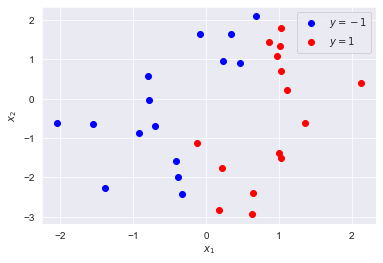

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Part 1: Primal Soft-Margin SVM

### 1.1 Realization of Primal Soft-Margin SVM

In [4]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training 
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """
    
    def __init__(self, eta, lambda0) -> None:
        super().__init__()
        
        # Initialise hyperparameters
        self.eta = eta  # Learning rate
        self.lambda0 = lambda0  # Regularisation term
        # Initialise parameters
        self.w = None
        self.b = None
        # Initialise training data
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        # Initialise loss function
        self.loss = None
        


    def fit(self, X, y, iterations = 100) -> None:
        super().fit(X=X,y=y)
        
        # Obtain training data
        self.X = X
        self.y = y
        self.n, self.d = self.X.shape
        # Set initial values of w and b to be all zero
        self.w = np.zeros((self.d,1))
        self.b = np.zeros((1,1))

        # Outer loop run through all iterations
        for epoch in range(iterations):
            # Shuffle the data index
            schedule = list(range(self.n))
            random.shuffle(schedule)
            # Inner loop run through all instances
            for i in schedule:
                # Obtain individual's X & y
                xi = self.X[i].reshape((self.d,1))  # Get individual's x vector
                yi = self.y[i].reshape((1,1))  # Get individual's y
                # Calculate value of 1-yi(w'xi+b)
                si = 1 - yi * (self.w.T @ xi + self.b)
                # Update w and b
                # when 1-yi(w'xi+b) >= 0
                if si >= 0:
                    self.w -= self.eta * (self.lambda0 * self.w - yi * xi)
                    self.b -= self.eta * (-yi)
                # when 1-yi(w'xi+b) < 0
                else:
                    self.w -= self.eta * (self.lambda0 * self.w)

        # Calculate value of loss function
        self.loss = ((1/2) * self.lambda0 * (self.w.T @ self.w) +
                     np.sum(np.maximum(1 - self.y*(self.X @ self.w + self.b).T, 0))).item()

        
        
            
    def predict(self, test_X) -> int: 
        super().predict(test_X = test_X)
        
        # Calculate prediction of w'X + b
        y_predict =  (test_X @ self.w + self.b).T
        # Calculate prediction of label
        label_predict = np.sign(y_predict)
        # Return prediction of label
        return label_predict
        

### 1.2 Implement Primal Soft-Margin SVM on Training Data

Accuracy is 0.9333


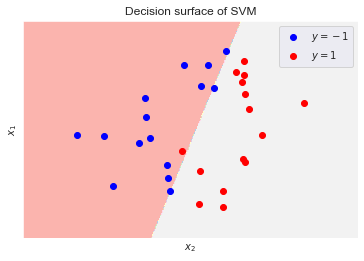

In [5]:
# Use this cell for experimentation 1.a
psvm_1a = PrimalSVM(eta = 0.1, lambda0 = 0.1)
psvm_1a.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm_1a.evaluate(X,y),4)}")
psvm_1a.visualize(X,y)

### 1.3 Tuning lambda value

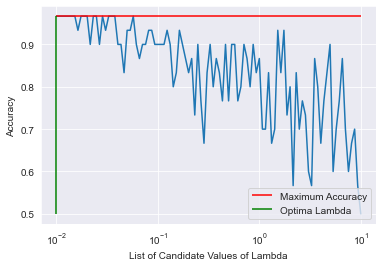

The plot shows that there are many values of lambda reach maximum accuracy; we use the smallest one among them.
The optima value of lambda is 0.01, which yield a maximum value of testing accuracy 0.9667.


In [6]:
# Use this cell for experimentation 1.b
# Create a list for candidate lambda
lambda_list_1b = np.logspace(-2,1,100)
# Create a list for accuracy corresponding to each value of lambda
acc_list_1b = []

# For each candidate lambda
for k in range(lambda_list_1b.size):
    # Train a SVM
    psvm_1b = PrimalSVM(eta = 0.1, lambda0 = lambda_list_1b[k])
    psvm_1b.fit(X, y, iterations = 100)
    # Calculate the accuracy
    acc_list_1b.append(psvm_1b.evaluate(X, y))

# Plot the value of lambda vs accuracy
plt.plot(lambda_list_1b, acc_list_1b)
plt.xscale("log")
plt.hlines(y = np.max(acc_list_1b), xmin = np.min(lambda_list_1b), xmax = np.max(lambda_list_1b),
           colors = 'red', label = 'Maximum Accuracy')
plt.vlines(x = lambda_list_1b[np.argmax(acc_list_1b)], ymin = np.min(acc_list_1b), ymax = np.max(acc_list_1b),
           colors = 'green', label = 'Optima Lambda')
plt.xlabel("List of Candidate Values of Lambda")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

# Show the optimal value of lambda with max accuracy
print("The plot shows that there are many values of lambda reach maximum accuracy; we use the smallest one among them.")
print(f"The optima value of lambda is {round(lambda_list_1b[np.argmax(acc_list_1b)], 4)},",
      f"which yield a maximum value of testing accuracy {round(np.max(acc_list_1b), 4)}.")

## Part 2: Dual Soft-Margin SVM

### 2.1 Realization of Dual Soft-Margin SVM

In [7]:
class DualSVM(SVM):

    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        # Initialise hyperparameters
        self.eta = eta  # Learning rate
        self.etas = None  # Learning rates for each instance
        self.C = C  # Regularisation term
        self.alphas = None  # Lagrange multipliers
        # Initialise parameters
        self.w = None
        self.b = None
        # Initialise training data set
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        self.loss = None
    
    def fit(self, X, y, iterations = 100):
        
        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        
        # Obtain training data
        self.X = X
        self.y = y.reshape((y.size,1))
        self.n, self.d = self.X.shape
        # Set initial values of w and b to be all zero
        self.w = np.zeros((self.d,1))
        self.b = np.zeros((1,1))
        # Set initial learning rates for each instance to be overall learning rate
        self.etas = np.full((self.n,1),self.eta)
        # Set initial lagrange multipliers for each instance to be zeros
        self.alphas = np.zeros((self.n,1))
        # Calculate kernel matrix
        K = self.kernel(self.X,self.X)

        # Outer loop run through all iterations
        for epoch in range(iterations):
            # Shuffle the data index
            schedule = list(range(self.n))
            random.shuffle(schedule)
            # Inner loop run through all instances
            for i in schedule:
                # Get individual's y
                yi = self.y[i].reshape((1,1))
                # Update individual's alpha according to Table 7.1 of Cristianini, N., & Shawe-Taylor, J. (2000)
                self.alphas[i] = self.alphas[i] + self.etas[i] * (1 - yi * ((self.alphas * self.y).T @ K[i,:]))
                if self.alphas[i] < 0:
                    self.alphas[i] = 0
                elif self.alphas[i] > self.C:
                    self.alphas[i] = self.C

        # Update equivalent primal weights and bias
        self.w = self.primal_weights()
        self.b = self.get_bias()

        # Calculate loss function
        self.loss = ((1/2) * (self.w.T @ self.w) +
                     self.C * np.sum(np.maximum(1 -  self.y*(self.X @ self.w + self.b), 0))).item()

        return
     
    def predict(self, test_X):
        super().predict(test_X = test_X)
        # Calculate kernel matrix
        K = self.kernel(test_X,self.X)
        # Calculate prediction of w'X + b
        y_predict = self.b + ((self.alphas * self.y).T @ K.T)
        # Calculate prediction of label
        label_predict = np.sign(y_predict)
        # Return prediction of label
        return label_predict
        
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        # Calculate w based on its formula
        w = ((self.alphas * self.y).T @ self.X).T
        return w
        
        
    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """
        # Calculate b based on its formula
        K = self.kernel(self.X,self.X)
        b = np.mean(self.y - (K @ (self.alphas * self.y)))
        return b
        

### 2.2 Implement Dual Soft-Margin SVM on Training Data

Accuracy is 0.9667


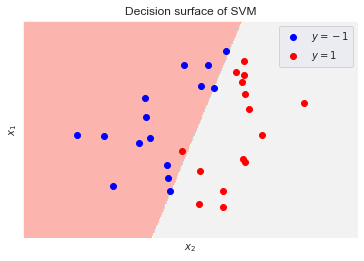

In [8]:
dsvm_2 = DualSVM(eta = 0.1, C = 100)
dsvm_2.fit(X, y, iterations = 100)
print(f"Accuracy is {round(dsvm_2.evaluate(X,y),4)}")
dsvm_2.visualize(X,y)

### 2.3 Tuning C value

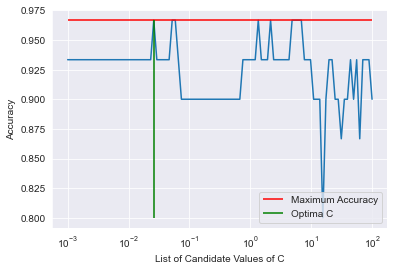

The plot shows that there are many values of C reach maximum accuracy; we use the smallest one among them.
The optima value of C is 0.026, which yield a maximum value of accuracy 0.9667.


In [9]:
# Create a list for candidate C
C_list_2a = np.logspace(-3,2,100)
# Create a list for accuracy corresponding to each value of C
acc_list_2a = []

# For each candidate C
for k in range(C_list_2a.size):
    # Train a SVM
    dsvm_2a = DualSVM(eta = 0.1, C = C_list_2a[k])
    dsvm_2a.fit(X, y, iterations = 100)
    # Calculate the accuracy
    acc_list_2a.append(dsvm_2a.evaluate(X, y))

# Plot the value of C vs accuracy
plt.plot(C_list_2a, acc_list_2a)
plt.xscale("log")
plt.hlines(y = np.max(acc_list_2a), xmin = np.min(C_list_2a), xmax = np.max(C_list_2a),
           colors = 'red', label = 'Maximum Accuracy')
plt.vlines(x = C_list_2a[np.argmax(acc_list_2a)], ymin = np.min(acc_list_2a), ymax = np.max(acc_list_2a),
           colors = 'green', label = 'Optima C')
plt.xlabel("List of Candidate Values of C")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

# Show the optimal value of C with max accuracy
print("The plot shows that there are many values of C reach maximum accuracy; we use the smallest one among them.")
print(f"The optima value of C is {round(C_list_2a[np.argmax(acc_list_2a)], 4)},",
      f"which yield a maximum value of accuracy {round(np.max(acc_list_2a), 4)}.")

### 2.4 Compare Weights between Primal and Dual

In [10]:
# Train a dual svm same as experimentation 2.a
dsvm_2b = DualSVM(eta = 0.1, C = 100)
dsvm_2b.fit(X, y, iterations = 100)
# Obtain training accuracy, loss, w from dual svm
acc_d = dsvm_2b.evaluate(X, y)
loss_d = dsvm_2b.loss
wd = dsvm_2b.w

# Set initial values for comparison
lambda_eq = None  # Equivalent lambda from primal svm
min_diff_w = np.Inf  # Minimum difference of w
min_diff_acc = np.Inf  # Minimum difference of accuracy
min_diff_loss = np.Inf  # Minimum difference of loss
wp_final = None # Equivalent w from primal svm

# List of candidate lambda
candidate_lambda = np.logspace(-4, 1, 1000)
# For each candidate lambda
for lambda0 in candidate_lambda:
    # Train a primal svm
    psvm_2b = PrimalSVM(eta = 0.1, lambda0 = lambda0)
    psvm_2b.fit(X,y, iterations = 100)
    # Obtain accuracy from primal svm and compare it with dual svm
    acc_p = psvm_2b.evaluate(X, y)
    diff_acc = abs(acc_p - acc_d)
    # Obtain loss from primal svm and compare it with dual svm
    loss_p = psvm_2b.loss
    diff_loss = abs(loss_p - loss_d / 100)
    # Obtain w from primal svm and compare it with dual svm (measured by norm of difference)
    wp = psvm_2b.w
    diff_w = wd/(wd.T@wd) - wp/(wp.T@wp)
    diff_w_norm = (diff_w.T @ diff_w).item()
    # Update equivalent lambda if this lambda yield a lower difference in accuracy and loss and w
    if diff_loss <= min_diff_loss and diff_acc <= min_diff_acc and diff_w_norm <= min_diff_w:
        lambda_eq = lambda0
        min_diff_acc = diff_acc
        min_diff_w = diff_w_norm
        min_diff_loss = diff_loss
        wp_final = wp

# Show the final result
print("The relationship between primal svm and dual svm can be concluded as follows: (1) The penalisation parameter in primal svm: lambda, and the penalisation parameter in dual svm: C, have the following relationship: C = 1 / lambda, i.e., C and lambda are reciprocals. (2) The loss function of dual svm is C times of the loss function of primal svm: Ld = C * Lp. These relationships may not hold exactly in reality, because the training process in two svm are different.")
print()
print(f"In this case, if we set C = 100 in dual svm, the equivalent lambda in primal svm is {round(lambda_eq, 4)}, which is not exactly 1 / C, but it is a relatively small number. If we set a large C, the equivalent lambda will be small. The reciprocal relationship basically holds.")
print()
print(f"In this case, the w of dual svm is {wd.T.round(4)}, and the related w for primal svm is {wp_final.T.round(4)}.")

The relationship between primal svm and dual svm can be concluded as follows: (1) The penalisation parameter in primal svm: lambda, and the penalisation parameter in dual svm: C, have the following relationship: C = 1 / lambda, i.e., C and lambda are reciprocals. (2) The loss function of dual svm is C times of the loss function of primal svm: Ld = C * Lp. These relationships may not hold exactly in reality, because the training process in two svm are different.

In this case, if we set C = 100 in dual svm, the equivalent lambda in primal svm is 0.1283, which is not exactly 1 / C, but it is a relatively small number. If we set a large C, the equivalent lambda will be small. The reciprocal relationship basically holds.

In this case, the w of dual svm is [[ 1.4306 -0.2814]], and the related w for primal svm is [[ 1.4816 -0.3243]].


### 2.5 Identify Support Vectors and Points where alpha=C

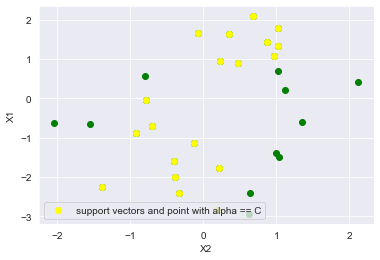

In [11]:
# Train a svm same as experiment 2
dsvm_2c = DualSVM(eta = 0.1, C = 100)
dsvm_2c.fit(X, y, iterations = 100)

# Identify the index for support vectors (alphai != 0) and point with alpha == C
index_list = []
for i in range(dsvm_2c.y.size):
    if dsvm_2c.alphas[i] != 0 or dsvm_2c.alphas[i] == dsvm_2c.C:
        index_list.append(i)

# Plot the points
plt.scatter(X[:,0], X[:,1], color = "green")
plt.scatter(X[index_list,0],X[index_list,1], color = "yellow", label = "support vectors and point with alpha == C")
plt.xlabel("X2")
plt.ylabel("X1")
plt.legend(loc='lower left')
plt.show()

## Part 3: Kernel

### 3.1 Realization of Kernel Class

In [12]:
from numpy.linalg import norm

class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    poly_degree: int
        Polynomial degree for polynormial kernel. 
    poly_offset: float
        Polynomial offset for polynomial kernel. 
    rbf_sigma: float
        Kernel coefficient for rbf kernel. 
    """
    
    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.sigma = kwargs.get('rbf_sigma')
            self.kernel = self.rbf_kernel
            
    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)
        
        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        return self.kernel(u, v)


    def linear_kernel(self, u, v):
        # Implement linear kernel according to its formula
        return np.dot(u,v.T).reshape(u.shape[0], v.shape[0])


    def poly_kernel(self, u, v):
        # Implement polynomial kernel according to its formula
        k = np.power(np.dot(u,v.T) + self.sigma, self.degree).reshape(u.shape[0], v.shape[0])
        return k
        
    def rbf_kernel(self, u, v):
        # Implement RBF kernel according to its formula
        u2 = (norm(u,axis=-1)**2).reshape(-1,1)
        v2 = (norm(v,axis=-1)**2).reshape(1,-1)
        uv = np.dot(u,v.T)
        k = np.exp((-1/(2*self.sigma)) * (u2 + v2 - 2*uv)).reshape(u.shape[0], v.shape[0])
        return k
        

### 3.2 Test Kernel in the DualSVM

Classification using linear kernel with tuned parameters (tunning process not shown here):
Accuracy is 0.9


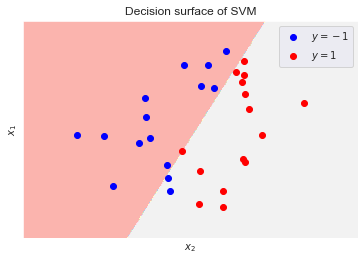

Classification using polynomial kernel with tuned parameters (tunning process not shown here):
Accuracy is 0.8667


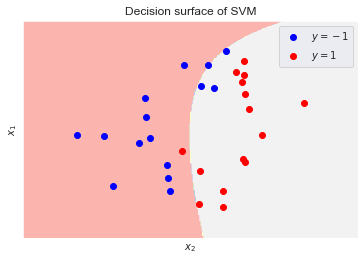

Classification using RBF kernel with tuned parameters (tunning process not shown here):
Accuracy is 1.0


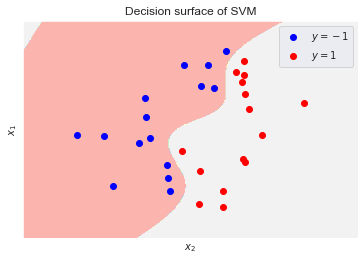

In [13]:
print("Classification using linear kernel with tuned parameters (tunning process not shown here):")
svm_3_1 = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
svm_3_1.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_3_1.evaluate(X,y),4)}")
svm_3_1.visualize(X,y)

print("Classification using polynomial kernel with tuned parameters (tunning process not shown here):")
svm_3_2 = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly', poly_degree=2, poly_offset = 4))
svm_3_2.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_3_2.evaluate(X,y),4)}")
svm_3_2.visualize(X,y)

print("Classification using RBF kernel with tuned parameters (tunning process not shown here):")
svm_3_3 = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf', rbf_sigma=1))
svm_3_3.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_3_3.evaluate(X,y),4)}")
svm_3_3.visualize(X,y)

Use this cell for your analysis for part 3.

In this case, the most appropriate kernel is linear kernel. In this data set, the two groups of instances is basically linear separable, with blue points on left and red points on right, with tiny violations. Therefore, a linear boundary is acceptable. In contrast, the polynomial kernel which produces a curvilinear boundary is under-fitting to the data, and the RBF kernel which produces a more flexible kernel is over-fitting to the data.

## Part 4: SMO

### 4.1 Realization of SMO Class

In [14]:
def random_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        i1 = random.randint(0,svm.n_samples-1)
        yield (i1, i2)

def all_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        for i1 in range(i2+1, svm.n_samples):
            yield (i1, i2)
    
class SMO(SVM):    
    def __init__(self, C, eps, tol, kernel, heuristic = all_pairs_heuristic):
        super().__init__()
        """Soft-margin SVM using dual formulation, training with sequential minimal optimization 
        """
        self.C = C
        self.eps = eps
        self.tol = tol
        self.kernel = kernel
        self.heuristic = heuristic
        
    def fit(self, X, y, iterations = 100):

        """Fit function for training SVM
        
        Parameters
        ----------
        iterations: int
            Stop training after this many iterations, even if not converged.
        """

        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        self.b = 0
        self.alphas = np.zeros(self.X.shape[0])
        self.n_samples, self.n_features = self.X.shape
        self.K = self.kernel(self.X, self.X)
        self.update_errors()
        
        num_changed = 1
        complete_pass = False
        epoch = 1
        total_changed = total_examined = 0
        for epoch in tqdm.trange(iterations):
            num_changed = num_examined = 0
            if not complete_pass:
                to_visit = self.heuristic(self)
            else:
                # force a full pass over all pairs of points
                # if previous epoch had no updates, to confirm
                # that model has converged
                to_visit = all_pairs_heuristic(self)
            for i1, i2 in to_visit:
                if self.__take_step(i1, i2):
                    num_changed += 1
                num_examined += 1

            epoch += 1
            total_changed += num_changed
            total_examined += num_examined
            if complete_pass and num_changed == 0:
                break
            complete_pass = (num_changed == 0)            
            
        if complete_pass and num_changed == 0:
            print('converged, total changed', total_changed, 'examined', total_examined)
        else:
            print('not converged, total changed', total_changed, 'examined', total_examined)

        return
    
    def lower(self, i1, i2):
        # Calculate lower bound by formula (13) and (14) in Platt, J. (1998)
        if self.y[i1] != self.y[i2]:
            return max(0, self.alphas[i2] - self.alphas[i1])
        else:
            return max(0, self.alphas[i2] + self.alphas[i1] - self.C)
        

    def higher(self, i1, i2):
        # Calculate higher bound by formula (13) and (14) in Platt, J. (1998)
        if self.y[i1] != self.y[i2]:
            return min(self.C, self.alphas[i2] - self.alphas[i1] + self.C)
        else:
            return min(self.C, self.alphas[i2] + self.alphas[i1])
        
    
    def update_errors(self):
        self.errors = np.dot(self.alphas * self.y, self.K) - self.b  - self.y

    def __take_step(self, i1, i2):
        if (i1 == i2):
            return False
        
        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        s = y1 * y2
        
        L = self.lower(i1, i2)
        H = self.higher(i1, i2)
        
        if L == H:
            return False
        
        # Calculate eta by formula (15) in Platt, J. (1998)
        Xi1 = self.X[i1].reshape(1,self.n_features)
        Xi2 = self.X[i2].reshape(1,self.n_features)

        k11 = self.kernel(Xi1,Xi1).item()
        k12 = self.kernel(Xi1,Xi2).item()
        k22 = self.kernel(Xi2,Xi2).item()

        eta = k11 + k22 - 2 * k12

        if eta <= 0:
            return False

        # Calculate new alpha2 by formula (15) in Platt, J. (1998)
        new_a2 = alpha2 + y2 * (E1 - E2) / eta
        if new_a2 < L:
            new_a2 = L
        elif new_a2 > H:
            new_a2 = H
                    
        if abs(new_a2-alpha2) < self.eps * (new_a2 + alpha2 + self.eps):
            return False
        
        # update alphas, bias and errors
        new_a1 = alpha1 + s * (alpha2 - new_a2)
        self.b = self.update_bias(new_a1, new_a2,  i1, i2, k11, k12, k22)
        self.update_errors()
        self.alphas[i1] = new_a1
        self.alphas[i2] = new_a2
        
        return True

    def update_bias(self, new_a1, new_a2, i1, i2, k11, k12, k22):

        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        
        # Calculate bias by formula (20) & (21) in Platt, J. (1998)
        b1 = E1 + y1 * (new_a1 - alpha1) * k11 + y2 * (new_a2 - alpha2) * k12 + self.b
        b2 = E2 + y1 * (new_a1 - alpha1) * k12 + y2 * (new_a2 - alpha2) * k22 + self.b
        if 0 < alpha1 < self.C:
            return b1
        elif 0 < alpha2 < self.C:
            return b2
        else:
            return (b1 + b2) / 2
        
    
    def predict(self, test_X):
        super().predict(test_X = test_X)
        
        # Calculate kernel matrix
        K = self.kernel(test_X,self.X)
        # Calculate prediction of w'X + b
        y_predict = -self.b + (K @ (self.alphas * self.y))
        # Calculate and return prediction of label
        label_predict = np.sign(y_predict).T
        return label_predict
           

  6%|▌         | 6/100 [00:00<00:00, 116.46it/s]


converged, total changed 84 examined 3045
Accuracy is 0.9667


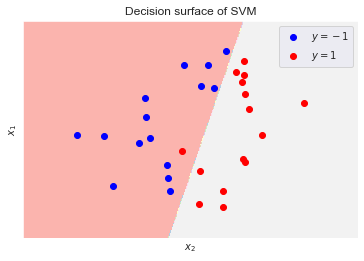

In [15]:
# Use this cell here for experimentation 4
svm_4 = SMO(C = 1,eps = 0.01,tol = 0.001, kernel = Kernel('linear'))
svm_4.fit(X, y, iterations = 100)
print(f"Accuracy is {round(svm_4.evaluate(X,y),4)}")
svm_4.visualize(X,y)

Classification using linear kernel:


  6%|▌         | 6/100 [00:00<00:00, 101.33it/s]

converged, total changed 84 examined 3045
Accuracy is 0.9667


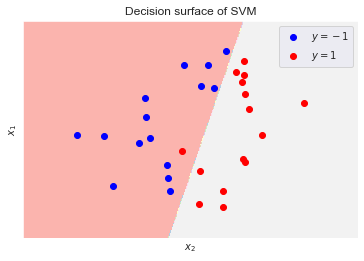

Classification using polynomial kernel:


 22%|██▏       | 22/100 [00:00<00:00, 86.46it/s]


converged, total changed 378 examined 10005
Accuracy is 0.9333


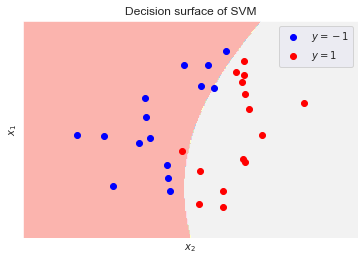

Classification using RBF kernel:


 16%|█▌        | 16/100 [00:00<00:02, 38.67it/s]


converged, total changed 196 examined 7395
Accuracy is 0.9333


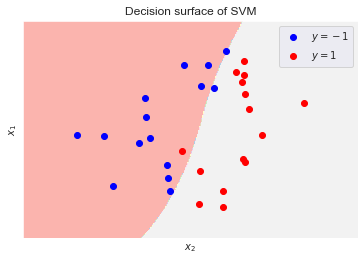

In [16]:
print("Classification using linear kernel:")
svm_4a_1 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('linear'))
svm_4a_1.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_4a_1.evaluate(X,y),4)}")
svm_4a_1.visualize(X,y)

print("Classification using polynomial kernel:")
svm_4a_2 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('poly', poly_degree=2, poly_offset = 4))
svm_4a_2.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_4a_2.evaluate(X,y),4)}")
svm_4a_2.visualize(X,y)

print("Classification using RBF kernel:")
svm_4a_3 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('rbf', rbf_sigma=2))
svm_4a_3.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm_4a_3.evaluate(X,y),4)}")
svm_4a_3.visualize(X,y)


### 4.2 Fashion MNIST Dataset and Heuristic Functions

The code below loads a part of the fashion-MNIST dataset, comprising pictures of clothing. The challenge is to classify the clothing by type. We have taken just two classes.

/Users/mac/opt/anaconda3/envs/Python_3_9/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


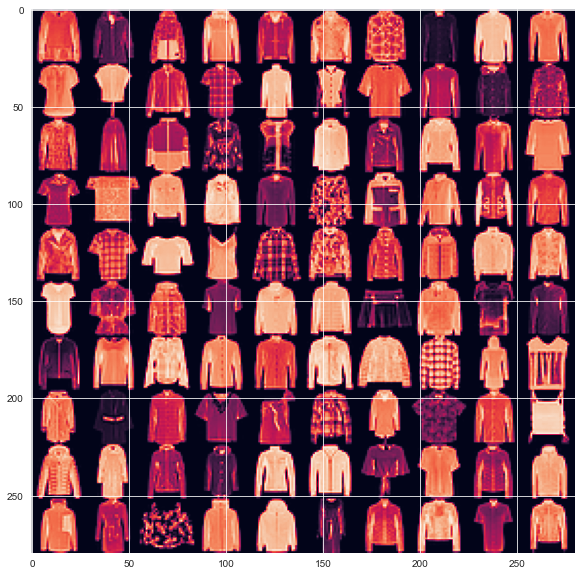

In [17]:
# extract a stack of 28x28 bitmaps
from sklearn.model_selection import train_test_split
%pylab inline

pics = np.loadtxt('train.csv', delimiter=' ')
Xf = pics[:, 0:784]
Xf = np.array([i/255 for i in Xf])

# extract labels for each bitmap
yf = pics[:, 784:785]
yf = np.array([int(i[0]) for i in yf])

# display a sample of the data
def gallery(array, ncols):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape((nrows, ncols, height, width))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols)))
    return result

ncols = 10
result = gallery(Xf.reshape((1200, 28, 28))[:ncols**2], ncols)
plt.figure(figsize=(10,10))
plt.imshow(result, interpolation=None)

# split data into a modest size training set, reserving the rest for testing
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=600, random_state=RND_SEED)

In [18]:
print("Classification using linear kernel by tuned hyperparameter (tuning process not shown here):")
svm_4b_1 = SMO(C = 100, eps = 0.1578, tol = 0.001, kernel = Kernel('linear'))
svm_4b_1.fit(X_train, y_train, iterations = 100)
print(f"Training accuracy is {round(svm_4b_1.evaluate(X_train,y_train),4)}")
print(f"Testing accuracy is {round(svm_4b_1.evaluate(X_test,y_test),4)}")
print()

print("Classification using polynomial kernel by tuned hyperparameter (tuning process not shown here):")
svm_4b_2 = SMO(C = 100, eps = 0.0105, tol = 0.001, kernel = Kernel('poly', poly_degree=2, poly_offset = 4))
svm_4b_2.fit(X_train, y_train, iterations = 100)
print(f"Training accuracy is {round(svm_4b_2.evaluate(X_train,y_train),4)}")
print(f"Testing accuracy is {round(svm_4b_2.evaluate(X_test,y_test),4)}")
print()

print("Classification using RBF kernel by tuned hyperparameter (tuning process not shown here):")
svm_4b_3 = SMO(C = 100, eps = 0.4278, tol = 0.001, kernel = Kernel('rbf', rbf_sigma=2))
svm_4b_3.fit(X_train, y_train, iterations = 100)
print(f"Training accuracy is {round(svm_4b_3.evaluate(X_train,y_train),4)}")
print(f"Testing accuracy is {round(svm_4b_3.evaluate(X_test,y_test),4)}")


Classification using linear kernel by tuned hyperparameter (tuning process not shown here):


 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]


converged, total changed 861 examined 4133100
Training accuracy is 0.9583
Testing accuracy is 0.8233

Classification using polynomial kernel by tuned hyperparameter (tuning process not shown here):


 10%|█         | 10/100 [00:38<05:45,  3.84s/it]


converged, total changed 911 examined 1976700
Training accuracy is 0.9733
Testing accuracy is 0.84

Classification using RBF kernel by tuned hyperparameter (tuning process not shown here):


 11%|█         | 11/100 [02:36<21:07, 14.25s/it]

converged, total changed 561 examined 2156400
Training accuracy is 1.0
Testing accuracy is 0.5383


In [19]:
# Define a custom heuristic function
def my_heuristic(svm):
    """A heuristic function of selecting which instance pairs
    to process (with __take_step) over a single SMO epoch. 

    Parameters
    ----------
    svm : SMO class
    ----------
    Return
    list of (int, int) tuples, the indices for pairs of training instances
    """
    
    # Obtain necessary information from the svm classifier
    y = svm.y
    E = svm.errors
    n = svm.n_samples
    a = svm.alphas
    C = svm.C

    # Create a temporary list for data points
    index_list = []

    # According to section 2.2 of Platt, J. (1998), we should select points that violate KKT conditions
    for i in range(n):
        # KKT condition defined in formula (12) in Platt, J. (1998)
        KKTi1 = y[i]*(y[i]-E[i]) >= 1 and a[i] == 0
        KKTi2 = y[i]*(y[i]-E[i]) == 1 and 0 < a[i] < C
        KKTi3 = y[i]*(y[i]-E[i]) <= 1 and a[i] == C
        # If point violate any KKT condition, select the point and point that yield max error difference with that point
        if (not KKTi1) or (not KKTi2) or (not KKTi3):
            if E[i] >= 0:
                k = np.argmin(E)
            else:
                k = np.argmax(E)
            index_list.append((i,k))

    # Return list of selected points
    return index_list

In [20]:
print("Classification using random pairs heuristic")
svm_4c_1 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('linear'), heuristic=random_pairs_heuristic)
svm_4c_1.fit(X, y, iterations = 100)
print(f"Training accuracy is {round(svm_4c_1.evaluate(X,y),4)}")
print()

print("Classification using all pairs heuristic")
svm_4c_2 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('linear'), heuristic=all_pairs_heuristic)
svm_4c_2.fit(X, y, iterations = 100)
print(f"Training accuracy is {round(svm_4c_2.evaluate(X,y),4)}")
print()

print("Classification using heuristic suggested by Platt, J. (1998)")
svm_4c_3 = SMO(C = 1, eps = 0.01, tol = 0.001, kernel = Kernel('linear'), heuristic=my_heuristic)
svm_4c_3.fit(X, y, iterations = 100)
print(f"Training accuracy is {round(svm_4c_3.evaluate(X,y),4)}")
print()

print("The svm using our heuristic function converges in 12 iterations, which is faster than that using random heuristic that randomly select pairs of data points (22 iterations), but slower than that using all-pairs heuristic that selecting all pairs of points (6 iterations). This is because that our heuristic analytically select data points that yield best training performance, which may or may not have actual best training performance in reality. Random heuristic select data points for training randomly, whose performance is actually not guaranteed. All-paris heuristic examine all pairs of data points, which can absolutely yield the best training performance. All three methods have the same training accuracy.")

Classification using random pairs heuristic


 19%|█▉        | 19/100 [00:00<00:00, 469.45it/s]


converged, total changed 91 examined 2220
Training accuracy is 0.9667

Classification using all pairs heuristic


  6%|▌         | 6/100 [00:00<00:01, 88.92it/s]


converged, total changed 84 examined 3045
Training accuracy is 0.9667

Classification using heuristic suggested by Platt, J. (1998)


 12%|█▏        | 12/100 [00:00<00:00, 161.24it/s]

converged, total changed 84 examined 2820
Training accuracy is 0.9667

The svm using our heuristic function converges in 12 iterations, which is faster than that using random heuristic that randomly select pairs of data points (22 iterations), but slower than that using all-pairs heuristic that selecting all pairs of points (6 iterations). This is because that our heuristic analytically select data points that yield best training performance, which may or may not have actual best training performance in reality. Random heuristic select data points for training randomly, whose performance is actually not guaranteed. All-paris heuristic examine all pairs of data points, which can absolutely yield the best training performance. All three methods have the same training accuracy.
